In [1]:
from thinkbayes2 import Pmf, Cdf, Suite, MakeJoint
import thinkplot

import pymc3 as pm
import numpy as np
import pandas as pd

from pymc3.math import exp, log

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def plotCdf(values, *args, **kwargs):
    thinkplot.Cdf(Cdf(values), *args, **kwargs)

# Problem Description
In the 2018 season of Major League Baseball...

We want to estimate which team is the best team, and ...

To accomplish this, we build an object-oriented PyMC model that predicts the expected number of runs scored by a given team in a game against another team. The model also includes mechanisms for representing properties of Baseball as a game, allowing it to build a Bayesian estimate of the mean score in a baseball game and the additional runs that a team is expected to get from having home field advantage.

In [112]:
class Baseball(object):
    """
    A Baseball object contains properties about fundamental properties of 
    the sport of Baseball itself, represented with PyMC3 distributions.
    """
    
    def __init__(self, name='baseball'):
        self.name = name
        
        self.mean_score = pm.Normal(f'{name}.mean_score', mu=4.45, sd=1) # Based on 2018 MLB season
        self.home_field_advantage = pm.Exponential(f'{name}.home_field_advantage', lam=5)
        
        self.offense_weight = pm.Normal(f'{name}.offense_weight', mu=1, sd=0.5)
        self.defense_weight = pm.Normal(f'{name}.defense_weight', mu=1, sd=0.5)
        
    def get_runs(self, team, opponent):
        return self.mean_score * exp(team.off_quality * self.offense_weight - opponent.def_quality * self.defense_weight)

The model we use for runs is a Poisson process with parameter dependent on the skills of both teams, as well as which team has home field advantage. In particular, we model the expected number of runs a given team will score in a game as 

$$k_{baseball} * \frac{e^{a(offense_{you})}}{e^{b(defense_{opponent})}} + home\_field\_boost$$

where

\begin{cases} 
      home\_field\_boost =  & x\leq 0 \\
      \frac{100-x}{100} & 0\leq x\leq 100 \\
      0 & 100\leq x 
   \end{cases}

A team's expected runs scored is dependent on both the team's offensive (run creation) skill and the opponent's defensive (run prevention) skill, while `a` and `b` in the above equation represent the relative weights of those two parameters.

In [113]:
class Team(object):
    def __init__(self, name, baseball):
        self.name = name
        self.baseball = baseball
        
        self.off_quality = pm.Normal(f'{name}.off_quality', mu=0, sd=1)
        self.def_quality = pm.Normal(f'{name}.def_quality', mu=0, sd=1)

    def model_game(self, opponent, homefield : bool, date, observed_runs_scored=None, observed_runs_allowed=None):
        expected_runs_scored = self.baseball.get_runs(self, opponent)
        expected_runs_allowed = self.baseball.get_runs(opponent, self)

        if homefield:
            expected_runs_scored += self.baseball.home_field_advantage
        else:
            expected_runs_allowed += self.baseball.home_field_advantage

        pm.Poisson(f'{date}_{self.name}', mu=expected_runs_scored, observed=observed_runs_scored)
        pm.Poisson(f'{date}_{opponent.name}', mu=expected_runs_allowed, observed=observed_runs_allowed)


In [114]:
team_names = ['BOS', 'NYY', 'TBR', 'TOR', 'BAL']
team_games = {}
for team in team_names:
    data = pd.read_csv(f'../data/{team.lower()}.csv')
    df = data[['Date', 'Opp', 'Unnamed: 4', 'R', 'RA']]
    df = df.loc[df['Opp'].isin(team_names)]
    df = df.rename(index=str, columns={'Unnamed: 4': 'Home'})
    df['Home'] = df['Home'].apply(lambda x: False if x == '@' else True)
    team_games[team] = df


In [115]:
modeled_games = {}
num_games = 0
runs = {}
allowed = {}

with pm.Model() as model:
    bb = Baseball()

    teams = {name: Team(name, bb) for name in team_names}

    for name, games in team_games.items():
        for index, game in games.head(40).iterrows():
            date = game['Date']
            opp = game['Opp']
            if not (opp, date) in modeled_games:
                modeled_games[(name, date)] = True
                num_games += 1
                teams[name].model_game(teams[opp], game['Home'], date, game['R'], game['RA'])

BOS TBR Thursday Mar 29 4.0 6.0
BOS TBR Friday Mar 30 1.0 0.0
BOS TBR Saturday Mar 31 3.0 2.0
BOS TBR Sunday Apr 1 2.0 1.0
BOS TBR Thursday Apr 5 3.0 2.0
BOS TBR Saturday Apr 7 10.0 3.0
BOS TBR Sunday Apr 8 8.0 7.0
BOS NYY Tuesday Apr 10 14.0 1.0
BOS NYY Wednesday Apr 11 7.0 10.0
BOS NYY Thursday Apr 12 6.0 3.0
BOS BAL Friday Apr 13 7.0 3.0
BOS BAL Saturday Apr 14 10.0 3.0
BOS BAL Sunday Apr 15 3.0 1.0
BOS TOR Tuesday Apr 24 3.0 4.0
BOS TOR Wednesday Apr 25 4.0 3.0
BOS TOR Thursday Apr 26 5.0 4.0
BOS TBR Friday Apr 27 3.0 4.0
BOS TBR Saturday Apr 28 6.0 12.0
BOS TBR Sunday Apr 29 4.0 3.0
BOS NYY Tuesday May 8 2.0 3.0
BOS NYY Wednesday May 9 6.0 9.0
BOS NYY Thursday May 10 5.0 4.0
BOS TOR Friday May 11 3.0 5.0
BOS TOR Saturday May 12 5.0 2.0
BOS TOR Sunday May 13 5.0 3.0
BOS BAL Thursday May 17 6.0 2.0
BOS BAL Friday May 18 4.0 7.0
BOS BAL Saturday May 19 6.0 3.0
BOS BAL Sunday May 20 5.0 0.0
BOS TBR Tuesday May 22 4.0 2.0
BOS TBR Wednesday May 23 4.0 1.0
BOS TBR Thursday May 24 3.0 6.0

In [116]:
# Inspect the prior distribution

with model:
    prior_trace = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [BAL.def_quality, BAL.off_quality, TOR.def_quality, TOR.off_quality, TBR.def_quality, TBR.off_quality, NYY.def_quality, NYY.off_quality, BOS.def_quality, BOS.off_quality, baseball.defense_weight, baseball.offense_weight, baseball.home_field_advantage, baseball.mean_score]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:10<00:00, 59.37draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


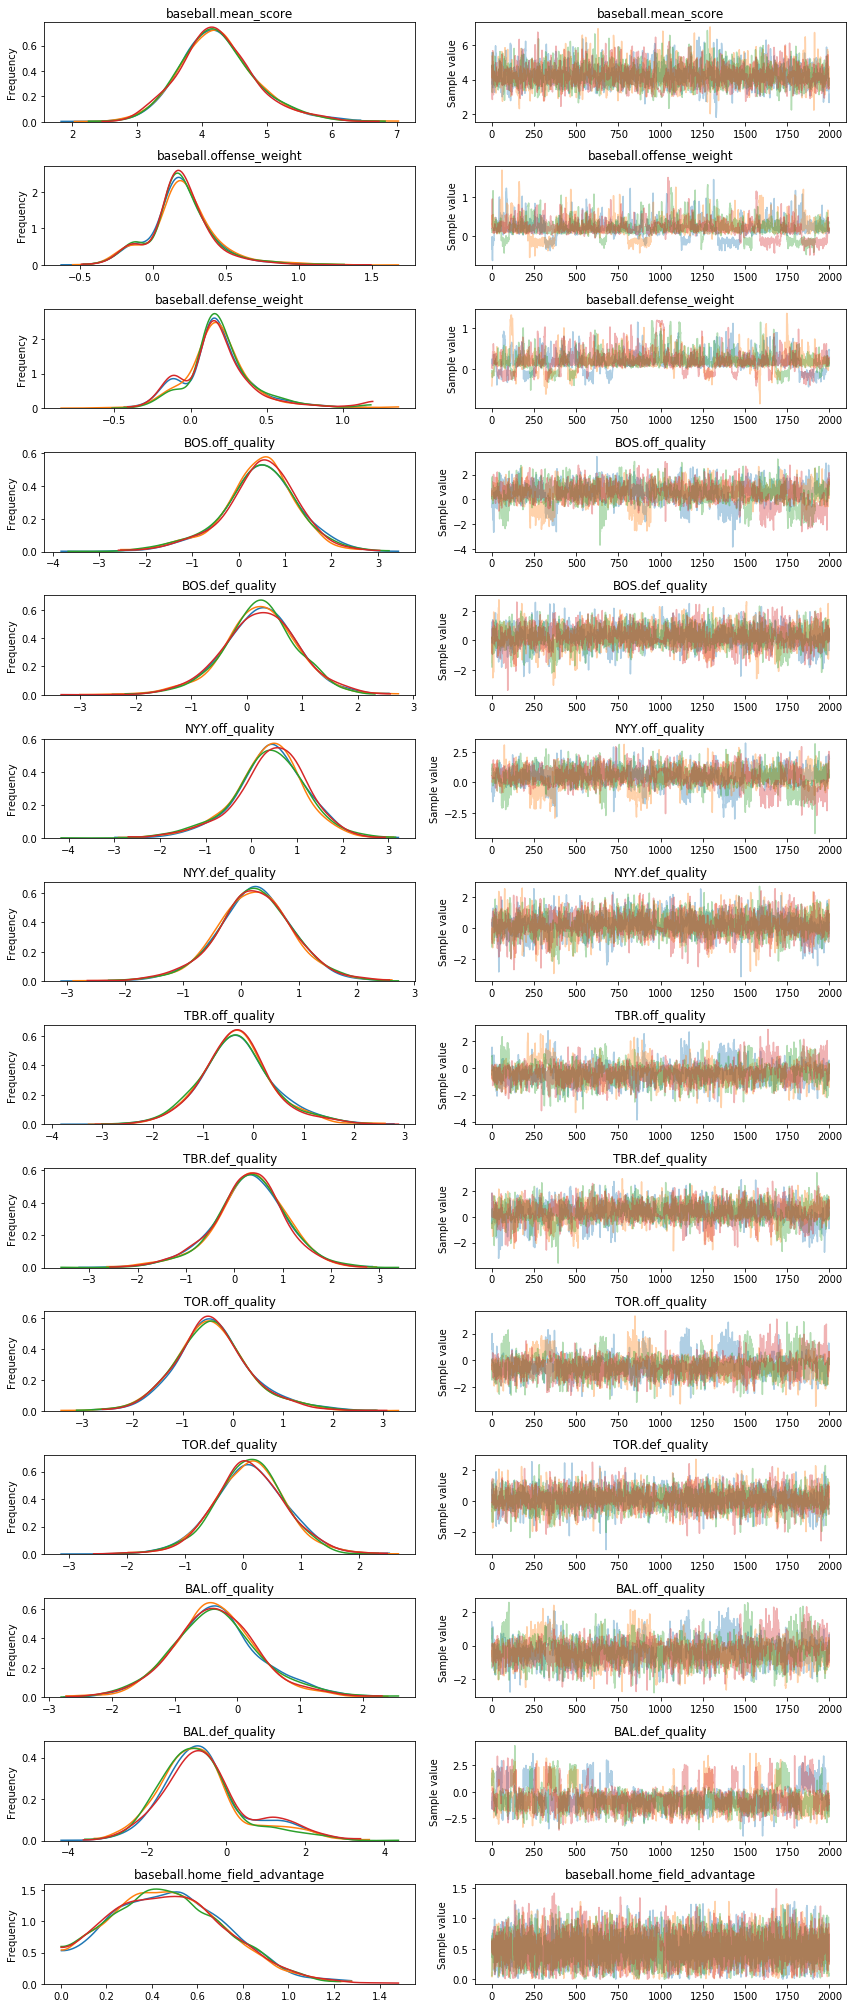

In [139]:
# Infer the posterior distributions
with model:
    trace = pm.sample(2000, tune=1000, cores=4, nuts_kwargs=dict(target_accept=.95))
    
pm.traceplot(trace);

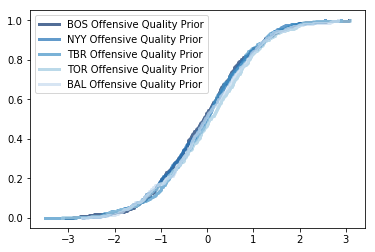

<Figure size 576x432 with 0 Axes>

In [140]:
for t in team_names:
    plotCdf(prior_trace[f'{t}.off_quality'], label=f'{t} Offensive Quality Prior')
thinkplot.Show()

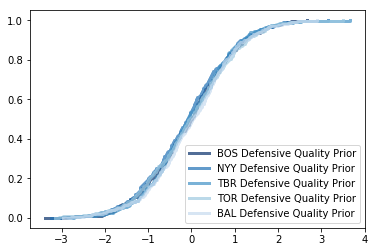

<Figure size 576x432 with 0 Axes>

In [141]:
for t in team_names:
    plotCdf(prior_trace[f'{t}.def_quality'], label=f'{t} Defensive Quality Prior')
thinkplot.Show()

The respective posterior distributions align with what we would expect from these teams qualitatively (and from looking at their first 10 inter-division games, quantitatively).

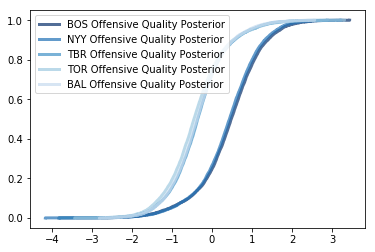

<Figure size 576x432 with 0 Axes>

In [142]:
for t in team_names:
    plotCdf(trace[f'{t}.off_quality'], label=f'{t} Offensive Quality Posterior')
thinkplot.Show()

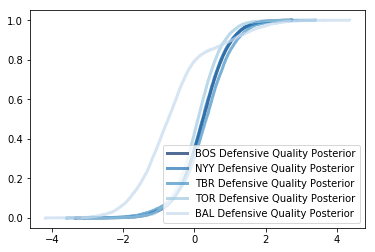

<Figure size 576x432 with 0 Axes>

In [143]:
for t in team_names:
    plotCdf(trace[f'{t}.def_quality'], label=f'{t} Defensive Quality Posterior')
thinkplot.Show()

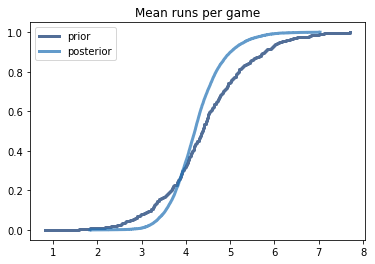

In [144]:
plotCdf(prior_trace['baseball.mean_score'], label='prior')
plotCdf(trace['baseball.mean_score'], label='posterior')
thinkplot.Config(title='Mean runs per game')

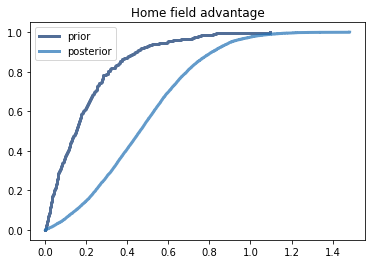

In [145]:
plotCdf(prior_trace['baseball.home_field_advantage'], label='prior')
plotCdf(trace['baseball.home_field_advantage'], label='posterior')
thinkplot.Config(title='Home field advantage')

0.540125 chance that BOS offense is better than NYY offense


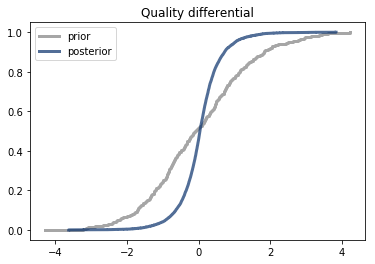

In [146]:
def plot_better(better, worse, attr, attr_name):
    plotCdf(prior_trace[f'{better}.{attr}'] - prior_trace[f'{worse}.{attr}'], label='prior', color='grey')
    plotCdf(trace[f'{better}.{attr}'] - trace[f'{worse}.{attr}'], label='posterior')
    thinkplot.Config(title='Quality differential')

    win_chance=np.mean((trace[f'{better}.{attr}'] - trace[f'{worse}.{attr}'])>0)
    print(f'{win_chance} chance that {better} {attr_name} is better than {worse} {attr_name}')

plot_better('BOS', 'NYY', 'off_quality', 'offense') # What really matters

0.50675 chance that BOS defense is better than NYY defense


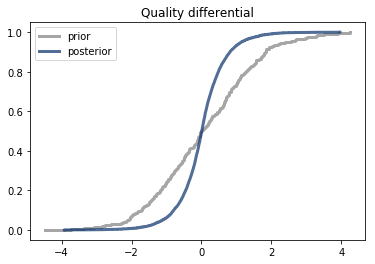

In [147]:
plot_better('BOS', 'NYY', 'def_quality', 'defense')

In [148]:
# Logic borrowed from Eric's ranking project
best_off_teams = []
best_def_teams = []
for i in range(len(trace)):
    best_off_teams.append(max(team_names, key=lambda name: trace[f'{name}.off_quality'][i]))
    best_def_teams.append(max(team_names, key=lambda name: trace[f'{name}.def_quality'][i]))

from collections import Counter

for team, count in Counter(best_off_teams).most_common():
    print(f'{team} offense is best with probability {count/len(trace)*100:.1f}%')
    
print()
for team, count in Counter(best_def_teams).most_common():
    print(f'{team} defense is best with probability {count/len(trace)*100:.1f}%')

BOS offense is best with probability 46.9%
NYY offense is best with probability 37.4%
TOR offense is best with probability 5.7%
TBR offense is best with probability 5.7%
BAL offense is best with probability 4.3%

TBR defense is best with probability 33.0%
BOS defense is best with probability 22.2%
NYY defense is best with probability 18.4%
BAL defense is best with probability 17.9%
TOR defense is best with probability 8.6%
